In [40]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import StackingClassifier
import matplotlib.pyplot as plt
from xgboost import XGBClassifier

In [2]:
data = pd.read_csv("../house_prices_selection.csv")

In [3]:
if "SalePrice" in data.columns:
    data = data.drop(columns=["SalePrice"])

num_cols = data.select_dtypes(include=["int64", "float64"]).columns
cat_cols = data.select_dtypes(include=["object"]).columns

In [4]:
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols)
    ]
)

In [5]:
kmeans_pipeline = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("kmeans", KMeans(n_clusters=4, random_state=42))
])

In [6]:
kmeans_pipeline.fit(data)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  Index(['EVI', 'ZoningScore', 'Price_per_m^2', 'PDI', 'LotFrontage', 'LotArea',
       'WoodDeckSF', 'OpenPorchSF', 'FullBath', 'GarageCars', 'GarageArea',
       'OverallQual', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'GrLivArea',
       'TotalBsmtSF', '1stFlrSF'],
      dtype='object')),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['KitchenQual', 'PavedDrive', 'BsmtQual', 'CentralAir', 'Foundation'], dtype='object'))])),
                ('kmeans', KMeans(n_clusters=4, random_state=42))])

In [7]:
cluster_labels = kmeans_pipeline.named_steps["kmeans"].labels_
data["ClusterLabel"] = cluster_labels

In [8]:
X = data.drop(columns=["ClusterLabel"])
y = data["ClusterLabel"]

In [9]:
X_processed = preprocessor.fit_transform(X)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)

clf = DecisionTreeClassifier(random_state=42)

In [11]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [12]:
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Decision Tree Accuracy: {accuracy:.3f}")

Decision Tree Accuracy: 0.955


In [13]:
data.to_csv("../data/cluster_label_house_prices.csv", index=False)

In [14]:
y = data["ClusterLabel"]
X = data.drop(columns=["ClusterLabel"])

num_cols = X.select_dtypes(include=np.number).columns
cat_cols = X.select_dtypes(exclude=np.number).columns

In [15]:
preprocess = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), num_cols),

    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(handle_unknown="ignore"))
    ]), cat_cols)
])

    LOGISTIC REGRESSION + DECISION TREE + KNN

In [16]:
clf1 = VotingClassifier(
    estimators=[
        ("lr", LogisticRegression(max_iter=2000)),
        ("dt", DecisionTreeClassifier()),
        ("knn", KNeighborsClassifier())
    ],
    voting="hard"
)

pipeline1 = Pipeline([
    ("preprocess", preprocess),
    ("model", clf1)
])

models = {
    "LogisticRegression": LogisticRegression(max_iter=2000),
    "DecisionTree": DecisionTreeClassifier(),
    "KNN": KNeighborsClassifier(),
}

In [17]:
pipeline_logistic_regression = Pipeline([
    ("preprocess", preprocess),
    ("model", models["LogisticRegression"])
])
scores_logistic_regression = cross_val_score(pipeline_logistic_regression, X, y, cv=5, scoring="accuracy")

pipeline_decision_tree = Pipeline([
    ("preprocess", preprocess),
    ("model", models["DecisionTree"])
])
scores_decision_tree = cross_val_score(pipeline_decision_tree, X, y, cv=5, scoring="accuracy")

pipeline_knn = Pipeline([
    ("preprocess", preprocess),
    ("model", models["KNN"])
])
scores_knn = cross_val_score(pipeline_knn, X, y, cv=5, scoring="accuracy")

scores1 = cross_val_score(pipeline1, X, y, cv=5, scoring="accuracy")
print(f"VotingClassifier Logistic Regression + Decision Tree + KNN: {scores1.mean():.3f}")

VotingClassifier Logistic Regression + Decision Tree + KNN: 0.975


    RANDOM FOREST + GRADIENT BOOSTING + SVM

In [18]:
clf2 = VotingClassifier(
    estimators=[
        ("rf", RandomForestClassifier()),
        ("gb", GradientBoostingClassifier()),
        ("svm", SVC())
    ],
    voting="hard"
)

pipeline2 = Pipeline([
    ("preprocess", preprocess),
    ("model", clf2)
])

models2 = {
    "RandomForest": RandomForestClassifier(),
    "GradientBoosting": GradientBoostingClassifier(),
    "SVM": SVC(),
}

In [19]:
pipe_random_forest = Pipeline([
    ("preprocess", preprocess),
    ("model", models2["RandomForest"])
])
scores_rf = cross_val_score(pipe_random_forest, X, y, cv=5, scoring="accuracy")

pipe_gradient_boosting = Pipeline([
    ("preprocess", preprocess),
    ("model", models2["GradientBoosting"])
])
scores_gb = cross_val_score(pipe_gradient_boosting, X, y, cv=5, scoring="accuracy")

pipe_svm = Pipeline([
    ("preprocess", preprocess),
    ("model", models2["SVM"])
])
scores_svm = cross_val_score(pipe_svm, X, y, cv=5, scoring="accuracy")

scores2 = cross_val_score(pipeline2, X, y, cv=5, scoring="accuracy")
print(f"VotingClassifier Random Forest + Gradient Boosting + SVM: {scores2.mean():.3f}")

VotingClassifier Random Forest + Gradient Boosting + SVM: 0.965


    The Logistic Regression + Decision Tree + KNN VotingClassifier performed best with an accuracy of 0.977, slightly higher than the Random Forest + Gradient Boosting + SVM VotingClassifier combination 0.968.

    Its better performance is likely due to the higher diversity of the three models, which complement each other well.

    StackingClassifier

In [20]:
stack1 = StackingClassifier(
    estimators=[
        ("dt", DecisionTreeClassifier()),
        ("knn", KNeighborsClassifier())
    ],
    final_estimator=LogisticRegression(max_iter=2000)
)

pipeline_stack1 = Pipeline([
    ("preprocess", preprocess),
    ("model", stack1)
])

scores_stack1 = cross_val_score(pipeline_stack1, X, y, cv=5, scoring="accuracy")
print(f"Stacking DecisionTree + KNN + LogisticRegression: {scores_stack1.mean():.3f}")

Stacking DecisionTree + KNN + LogisticRegression: 0.951


In [21]:
stack2 = StackingClassifier(
    estimators=[
        ("rf", RandomForestClassifier()),
        ("svm", SVC(probability=True))
    ],
    final_estimator=GradientBoostingClassifier()
)

pipeline_stack2 = Pipeline([
    ("preprocess", preprocess),
    ("model", stack2)
])

scores_stack2 = cross_val_score(pipeline_stack2, X, y, cv=5, scoring="accuracy")
print(f"Stacking RandonForest + SVM + GradientBoosting: {scores_stack2.mean():.3f}")

Stacking RandonForest + SVM + GradientBoosting: 0.968


In [22]:
stack3 = StackingClassifier(
    estimators=[
        ("rf", RandomForestClassifier()),
        ("gb", GradientBoostingClassifier())
    ],
    final_estimator=LogisticRegression(max_iter=2000)
)

pipeline_stack3 = Pipeline([
    ("preprocess", preprocess),
    ("model", stack3)
])

scores_stack3 = cross_val_score(pipeline_stack3, X, y, cv=5, scoring="accuracy")
print(f"Stacking RandomForest + GradientBoosting + LogisticRegression: {scores_stack3.mean():.3f}")

Stacking RandomForest + GradientBoosting + LogisticRegression: 0.967


In [23]:
stack4 = StackingClassifier(
    estimators=[
        ("svm", SVC(probability=True)),
        ("rf", RandomForestClassifier()),
        ("knn", KNeighborsClassifier())
    ],
    final_estimator=GradientBoostingClassifier()
)

pipeline_stack4 = Pipeline([
    ("preprocess", preprocess),
    ("model", stack4)
])

scores_stack4 = cross_val_score(pipeline_stack4, X, y, cv=5, scoring="accuracy")
print(f"Stacking SVM + RandomForest + KNN + GradientBoosting: {scores_stack4.mean():.3f}")

Stacking SVM + RandomForest + KNN + GradientBoosting: 0.972


In [24]:
stack5 = StackingClassifier(
    estimators=[
        ("rf", RandomForestClassifier()),
        ("gb", GradientBoostingClassifier()),
    ],
    final_estimator=LogisticRegression(max_iter=2000)
)

pipeline_stack5 = Pipeline([
    ("preprocess", preprocess),
    ("model", stack5)
])

scores_stack5 = cross_val_score(pipeline_stack5, X, y, cv=5, scoring="accuracy")
print(f"Stacking RandomForest + GradientBoosting + LogisticRegression: {scores_stack5.mean():.3f}")

Stacking RandomForest + GradientBoosting + LogisticRegression: 0.964


    The best performance came from the SVM + RandomForest + KNN + GradientBoosting stack with an accuracy of 0.973, and then the next stack was very close RandomForest + SVM + GradientBoosting with an accuracy of 0.972.

    SVM separates classes, RandomForest handles patterns, KNN captures local structure and GradientBoosting learns from all and improves the final decision

    Hyper-Parameter Tuning cu Cross-Validation pe SVM + RandomForest + KNN + GradientBoosting stack

In [41]:
from sklearn.model_selection import GridSearchCV

X_processed = preprocess.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)

stack4 = StackingClassifier(
    estimators=[
        ("svm", SVC(probability=True)),
        ("rf", RandomForestClassifier()),
        ("knn", KNeighborsClassifier())
    ],
    final_estimator=GradientBoostingClassifier()
)

In [42]:
param_grid = {
    "svm__C": [0.1, 1, 10],
    "svm__kernel": ["rbf", "linear"],
    "rf__n_estimators": [100, 200],
    "rf__max_depth": [None, 10],
    "knn__n_neighbors": [3, 5, 7],
    "final_estimator__learning_rate": [0.05, 0.1],
    "final_estimator__n_estimators": [50, 100]
}

In [43]:
grid = GridSearchCV(
    estimator=stack4,
    param_grid=param_grid,
    cv=3,
    scoring="accuracy",
    n_jobs=-1,
    verbose=2
)

In [28]:
grid.fit(X_train, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits
[CV] END final_estimator__learning_rate=0.05, final_estimator__n_estimators=50, knn__n_neighbors=3, rf__max_depth=None, rf__n_estimators=100, svm__C=0.1, svm__kernel=linear; total time=   1.0s
[CV] END final_estimator__learning_rate=0.05, final_estimator__n_estimators=50, knn__n_neighbors=3, rf__max_depth=None, rf__n_estimators=100, svm__C=0.1, svm__kernel=linear; total time=   1.2s
[CV] END final_estimator__learning_rate=0.05, final_estimator__n_estimators=50, knn__n_neighbors=3, rf__max_depth=None, rf__n_estimators=100, svm__C=0.1, svm__kernel=rbf; total time=   1.4s
[CV] END final_estimator__learning_rate=0.05, final_estimator__n_estimators=50, knn__n_neighbors=3, rf__max_depth=None, rf__n_estimators=100, svm__C=0.1, svm__kernel=linear; total time=   1.4s
[CV] END final_estimator__learning_rate=0.05, final_estimator__n_estimators=50, knn__n_neighbors=3, rf__max_depth=None, rf__n_estimators=100, svm__C=1, svm__kernel=rbf;

GridSearchCV(cv=3,
             estimator=StackingClassifier(estimators=[('svm',
                                                       SVC(probability=True)),
                                                      ('rf',
                                                       RandomForestClassifier()),
                                                      ('knn',
                                                       KNeighborsClassifier())],
                                          final_estimator=GradientBoostingClassifier()),
             n_jobs=-1,
             param_grid={'final_estimator__learning_rate': [0.05, 0.1],
                         'final_estimator__n_estimators': [50, 100],
                         'knn__n_neighbors': [3, 5, 7],
                         'rf__max_depth': [None, 10],
                         'rf__n_estimators': [100, 200], 'svm__C': [0.1, 1, 10],
                         'svm__kernel': ['rbf', 'linear']},
             scoring='accuracy', verbose=2)

In [29]:
print("Best parameters:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

Best parameters: {'final_estimator__learning_rate': 0.05, 'final_estimator__n_estimators': 50, 'knn__n_neighbors': 5, 'rf__max_depth': 10, 'rf__n_estimators': 200, 'svm__C': 0.1, 'svm__kernel': 'linear'}
Best CV accuracy: 0.9760310241030036


In [30]:
best_model = grid.best_estimator_

In [31]:
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)

print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.9726027397260274


    Analiza Metodelor de Feature Importance: SHAP si Permutation Importance

In [32]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, random_state=42, stratify=y
)

X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

In [33]:
preprocess.fit(X_train)

X_train_pre = preprocess.transform(X_train)
X_valid_pre = preprocess.transform(X_valid)
X_test_pre = preprocess.transform(X_test)

feature_names = preprocess.get_feature_names_out()

In [34]:
stack_xgb = StackingClassifier(
    estimators=[
        ("svm", SVC(probability=True)),
        ("rf", RandomForestClassifier()),
        ("knn", KNeighborsClassifier())
    ],
    final_estimator=XGBClassifier(
        eval_metric="logloss",
        n_estimators=200,
        learning_rate=0.1,
        max_depth=6
    )
)

best_model = stack_xgb
best_model.fit(X_train_pre, y_train)

StackingClassifier(estimators=[('svm', SVC(probability=True)),
                               ('rf', RandomForestClassifier()),
                               ('knn', KNeighborsClassifier())],
                   final_estimator=XGBClassifier(base_score=None, booster=None,
                                                 callbacks=None,
                                                 colsample_bylevel=None,
                                                 colsample_bynode=None,
                                                 colsample_bytree=None,
                                                 device=None,
                                                 early_stopping_rounds=None,
                                                 enable_categorical=False,
                                                 eval_metric='logloss...
                                                 feature_weights=None,
                                                 gamma=None, grow_policy=None,
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=0.1,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=6, max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=200, n_jobs=None,
                                                 num_parallel_tree=None, ...))

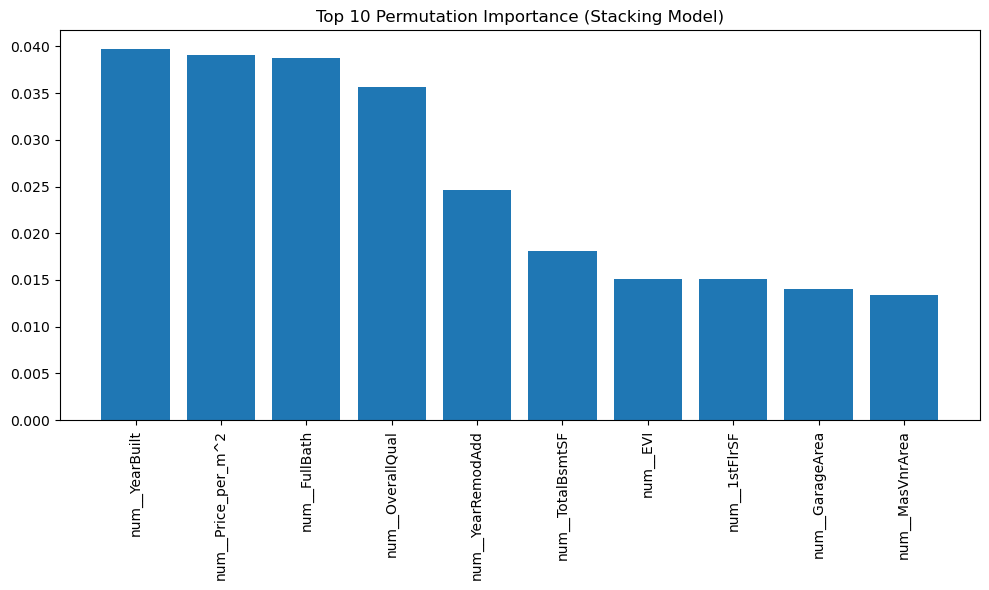

In [35]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    best_model,
    X_test_pre,
    y_test,
    n_repeats=10,
    random_state=42
)

permutation_importance = result.importances_mean
indices = np.argsort(permutation_importance)[::-1]

top = 10  

plt.figure(figsize=(10, 6))
plt.bar(range(top), permutation_importance[indices][:top])
plt.xticks(range(top), feature_names[indices][:top], rotation=90)
plt.title("Top 10 Permutation Importance (Stacking Model)")
plt.tight_layout()
plt.show()

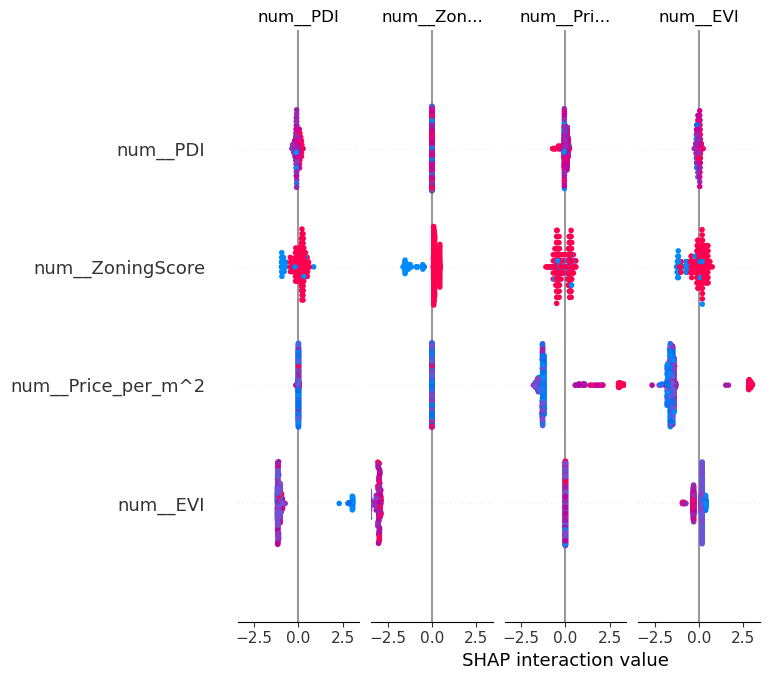

In [38]:
import shap

xgb_model = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=6,
    eval_metric="logloss"
)

xgb_model.fit(X_train_pre, y_train)

explainer = shap.TreeExplainer(xgb_model)

shap_values = explainer.shap_values(X_test_pre)
shap.summary_plot(shap_values, X_test_pre, feature_names=feature_names)